In [304]:
import numpy as np
import math
import random
from numpy.linalg import eig
import matplotlib.pyplot as plt

In [305]:
## Dividing vertices into clusters

N = 1000 ## Number of vertices
p = 0.5 ## Probability of being in cluster 1 (given two clusters)

def x_vec(N,p):
    '''
    x vector has value 1 at index i if ith vertex is in cluster 1, and it i has
    value -1 at index i if ith vertex is in cluster 2
    '''
    memberships = np.array([0 for count in range(N)])
    for e in range(N):
        memberships[e] = 2*int(random.uniform(0,1)>p)-1
    return memberships

def ones(N):
    '''
    NxN square matrix of all 1's
    '''
    ##NxN ones matrix
    ones = np.array([1 for count in range(N)])
    ones.shape = (N,1)
    one_mat = ones.dot(ones.T)
    return one_mat

def xxt(x_vec):
    '''
    Given a column vector x, return matrix xx^T
    '''
    x_vec.shape = (N,1)
    xxt = x_vec.dot(x_vec.T)
    return xxt

In [306]:
##Building Bernoulli adjacency matrix
def adj_matrix(delta, gamma, N, x):
    '''
    Given delta, gamma, x, and N, return the adjacency matrix
    '''
    zero_vec = np.array([0 for count in range(N)])
    adj_mat = np.array([zero_vec for count in range(N)])
    
    for i in range(N):
        adj_mat[i][i]=0
        for j in range(i+1, N):
            edge = int(random.uniform(0,1) > delta + gamma * x[i] * x[j])
            adj_mat[i][j] = edge
            adj_mat[j][i] = edge
    
    return adj_mat

In [307]:
def mod_adj(A, N, delta):
    '''
    Adjacency matrix subtracted by delta at every entry, then divided by a normalizing value
    '''
    diffA = A - delta * ones(N)
    return 1/math.sqrt(N*delta*(1-delta)) * diffA

In [308]:
##Wigner matrix
def Wigner(N):
    '''
    Construct an N-dimensional symmetric Wigner matrix
    '''
    W = [[0 for i in range(N)] for j in range(N)]
    for i in range(N):
        for j in range(i,N):
            W[i][j] = np.random.normal()
            W[j][i] = W[i][j]
    W = np.matrix(W)
    return W

In [309]:
def Gaussian_Adj(lam, xxt, N):
    '''
    Produce a spiked Wigner matrix, which is the sum of a normalized Wigner 
    and lambda/N * xxt
    '''
    Y = lam/N * xxt + math.sqrt(1/N)*W
    return Y

In [310]:
def lambda_max(M):
    '''
    Find maximum eigenvalue of any matrix
    '''
    return max(eig(M)[0])

In [311]:
def spectra(delta,gamma,N,p):
    '''
    1) Return the maximum eigenvalue of the adjacency matrix after it is subtracted by 
    delta at every entry and divided by sqrt(n*delta*(1-delta)) at every entry
    
    2) Return maximum eigenvalue of of beta/N xxt(x) + 1/math.sqrt(N)*Wigner(N),
    or the spiked Wigner analog to the scaled adjacency matrix
    '''
    x = x_vec(N,p)
    A = adj_matrix(delta, gamma, N, x)
    mod_adj_max_eig = lambda_max(mod_adj(A,N,delta))
    
    beta = gamma*math.sqrt(N)/math.sqrt(delta*(1-delta))
    gauss_max_eig = lambda_max(Gaussian_Adj(beta, xxt(x), N))
    
    print("Beta", beta)
    
    return mod_adj_max_eig, gauss_max_eig

In [312]:
def max_eigenvector(Z):
    '''
    Return eigenvector corresponding to maximum eigenvalue
    '''
    return np.linalg.eigh(Z)[1][:,-1]

In [313]:
def recover_x_from_spiked_wigner(x,N,beta):
    '''
    Recovering x (memberships vector) from Spiked Wigner, which contains Gaussian noise
    '''
    Y = Gaussian_Adj(beta, xxt(x),N)
    eigv_max = max_eigenvector(Y)
    for i in range(len(eigv_max)):
        '''
        Modifying eigenvector so every positive value becomes 1 and every negative value becomes -1
        '''
        if eigv_max[i]>0:
            eigv_max[i]=1
        else:
            eigv_max[i]=-1
    return eigv_max

In [314]:
def avg_dist_x_recovery(N_iters,N,p,beta):
    '''
    Finding on average, how far the recovered x is from the true x, given beta
    '''
    sum_dists = 0
    for i in range(N_iters):
        x = x_vec(N,p)
        recov = recover_x_from_spiked_wigner(x,N,beta)
        sum_dists += min(np.linalg.norm(x - recov),np.linalg.norm(x+recov)) ## Accounting for symmetry in recovery
    return sum_dists / N_iters

Text(0, 0.5, 'Distance')

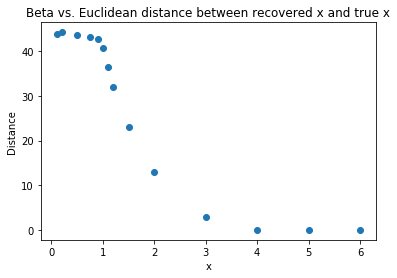

In [315]:
betas = [0.1,0.2,0.5,0.75,0.9,1,1.1,1.2,1.5,2,3,4,5,6]
dists = [avg_dist_x_recovery(10,1000,0.5,beta) for beta in betas]
plt.scatter(betas, dists)
plt.title("Beta vs. Euclidean distance between recovered x and true x")
plt.xlabel("x")
plt.ylabel("Distance")

In [316]:
def recover_x_from_adj(A,N,delta):
    '''
    Recover x from the modified adjacency matrix by taking the maximum eigenvector
    '''
    A_star = mod_adj(A,N,delta)
    eigv_max = max_eigenvector(A_star)
    for i in range(len(eigv_max)):
        if eigv_max[i]>0:
            eigv_max[i]=1
        else:
            eigv_max[i]=-1
    return eigv_max

In [317]:
def calc_beta(delta,gamma,N):
    '''
    Calculate beta, the value that must be compared to the threshold of 1 to determine
    if spike recovery is possible
    '''
    return gamma * math.sqrt(N)/math.sqrt(delta * (1-delta))

In [318]:
def accuracy_with_symmetry(x1,x2):
    nz = np.count_nonzero(x1-x2)
    return max(nz/len(x1), (len(x1)-nz)/len(x1))

In [321]:
N = 1000
p = 0.5
delta = 0.5
gamma = 0.2
x = x_vec(N,p)
A = adj_matrix(delta,gamma,N,x)
print(calc_beta(delta,gamma,N))
accuracy_with_symmetry(recover_x_from_adj(A,N,delta),x)

12.649110640673518


0.51

In [320]:
accuracy_with_symmetry(max_eigenvector(A),x)

1.0